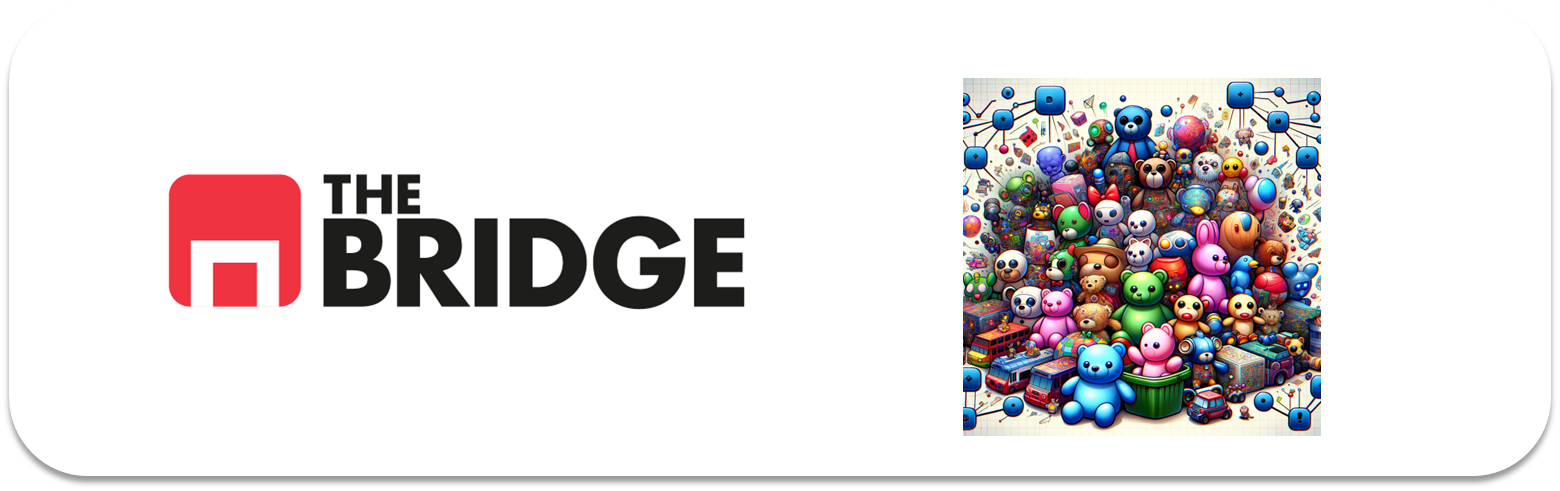

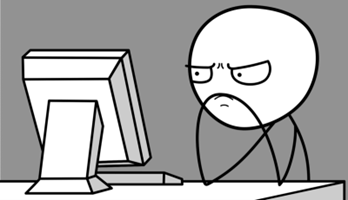

Para ejercitarte y afianzar lo aprendido sobre **DBSCAN**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Problema y "justificación": DBSCAN

Como sabemos, existen diversas técnicas de clusterización comprendidas por algoritmos de machine learning no supervisados, cuya finalidad es agrupar distintos elementos de una data sin la necesidad de estar previamente etiquetados. 

Anteriormente utilizamos el algoritmo de KMeans, sin embargo, dicho algoritmo tiene algunas limitaciones, como el hecho de que no siempre es sencillo obtener un número de K clusters óptimo o que algunas distribuciones de datos no se ajustan a la agrupación por clusters debido a la naturaleza del algoritmo. Para estos casos existen diversos algoritmos de clusterización. 

A continuación, vamos a utilizar el algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) para capturar grupos en data con patrones relativamente complejos.

Utilizaremos data de clientes de un distribuidor al por mayor, en el que se recogen por línea ventas a diferentes establecimientos y empresas de sus productos (aunque no se incluye el identificador de establecimiento) y cuyo objetivo es obtener agrupacioines interesantes (agrupaciones no predefinidas de productos que se suelen comprar juntos):

Features:

    1) FRESH: Gastos en productos frescos;
    2) MILK: Gastos en productos lacteos;
    3) GROCERY: Gastos en comestibles;
    4) FROZEN: Gastos en congelados;
    5) DETERGENTS_PAPER: Gastos en detergentes y derivados del papel;
    6) DELICATESSEN: Gatos en comestibles finos;
    7) CHANNEL: Canal que utilizan los clientes para vender - Horeca (Hotel/Restaurant/Cafeterías) o Retail channel (Al por menor);
    8) REGION: Región del cliente;

Fuente: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Evitar los warning
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Mejora características de impresión
from pprint import pprint

# Tratamiento de variables categóricas
from sklearn.preprocessing import OrdinalEncoder
pd.get_dummies # para one-hot encoding

# Tratamiento variables numéricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Separación df
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from EDA_function_tools import *
from toolbox_DS import *

### Ejercicio 1

Carga los datos y haz una primera exploración, incluyendo una descripción de las variables numéricas.

In [4]:
df = pd.read_csv('./data/wholesale-customers-data.csv')
df.head(8)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [9]:
describe_df(df).T

,DATE_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
Channel,int64,0.0,2,0.45
Region,int64,0.0,3,0.68
Fresh,int64,0.0,433,98.41
Milk,int64,0.0,421,95.68
Grocery,int64,0.0,430,97.73
Frozen,int64,0.0,426,96.82
Detergents_Paper,int64,0.0,417,94.77
Delicassen,int64,0.0,403,91.59


In [12]:
tipifica_variables(df,10,30)

,nombre_variable,tipo_sugerido
0,Channel,Binaria
1,Region,Categórica
2,Fresh,Numérica Continua
3,Milk,Numérica Continua
4,Grocery,Numérica Continua
5,Frozen,Numérica Continua
6,Detergents_Paper,Numérica Continua
7,Delicassen,Numérica Continua


In [14]:
df.describe().round(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,2.54,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,0.47,0.77,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11
min,1.00,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,2.00,3127.75,1533.00,2153.00,742.25,256.75,408.25
50%,1.00,3.00,8504.00,3627.00,4755.50,1526.00,816.50,965.50
75%,2.00,3.00,16933.75,7190.25,10655.75,3554.25,3922.00,1820.25
max,2.00,3.00,112151.00,73498.00,92780.00,60869.00,40827.00,47943.00


$$***$$

Es hora de hacer un miniEda (cuyo objetivo en el caso de clusterizacion no es obtener features para predicción de un target que no tenemos), cuyo objetivo es poder intuir posibles agrupaciones y su número, detectar si hay que hacer transformaciones y escalado en las variables y cuál

### Ejercicio 2



Pinta el histograma de las variables y determina cuáles podríamos considerar numéricas continuas y cuáles numéricas discretas (o categóricas)

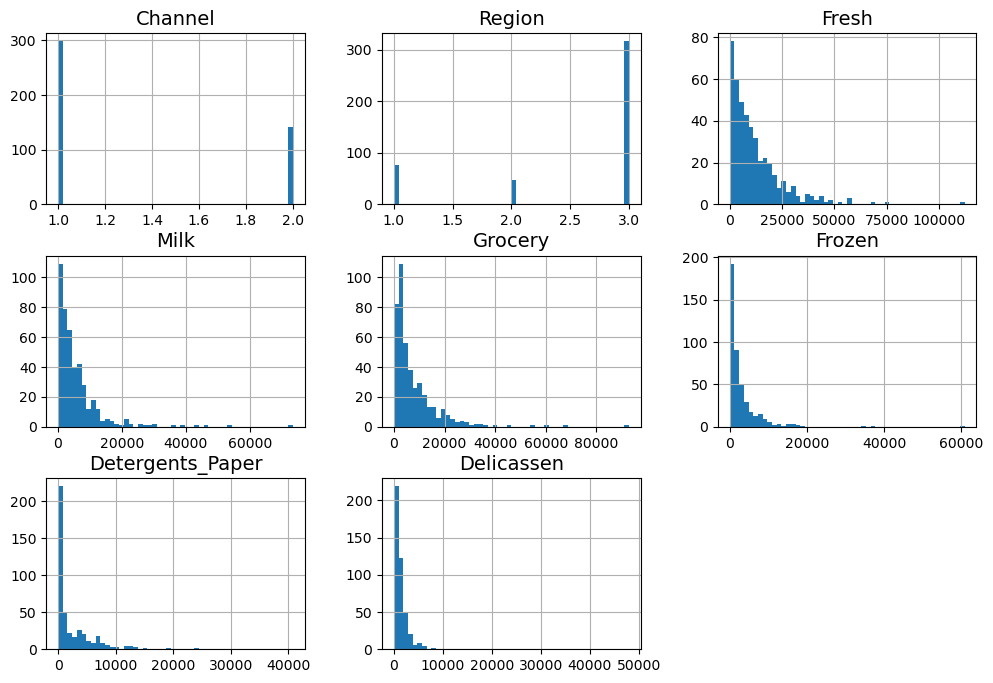

In [15]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8)) # La forma de generar histogramas de una sola vez para las variables numéricas de un dataset

plt.show()

In [16]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [17]:
features_num = ['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']

### Ejercicio 3

Antes de decidir sobre las agrupaciones, vamos pintar los histrogramas pero separando por canal (ya que es un elemento muy diferenciador del tipo de venta que se realiza a mayorista). Muestra graficamente para cada variable numérica su histograma para cada canal (Horeca y Retail). 

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


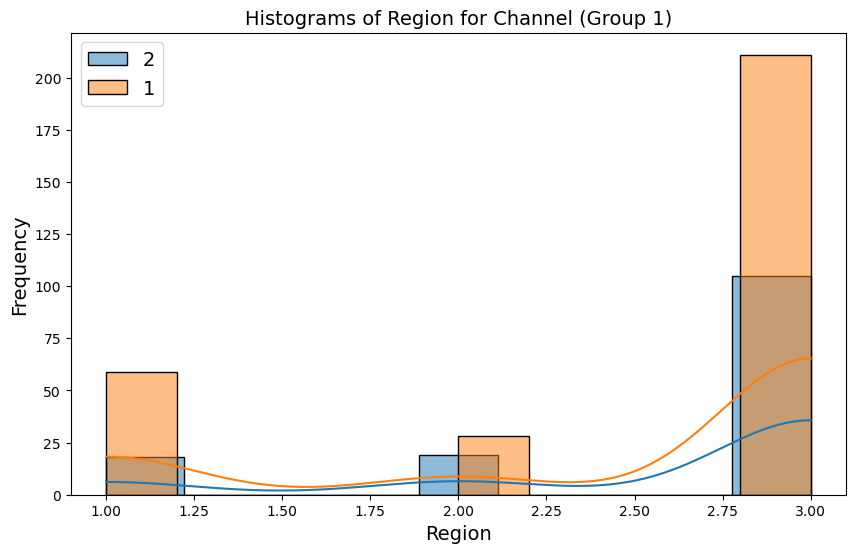

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


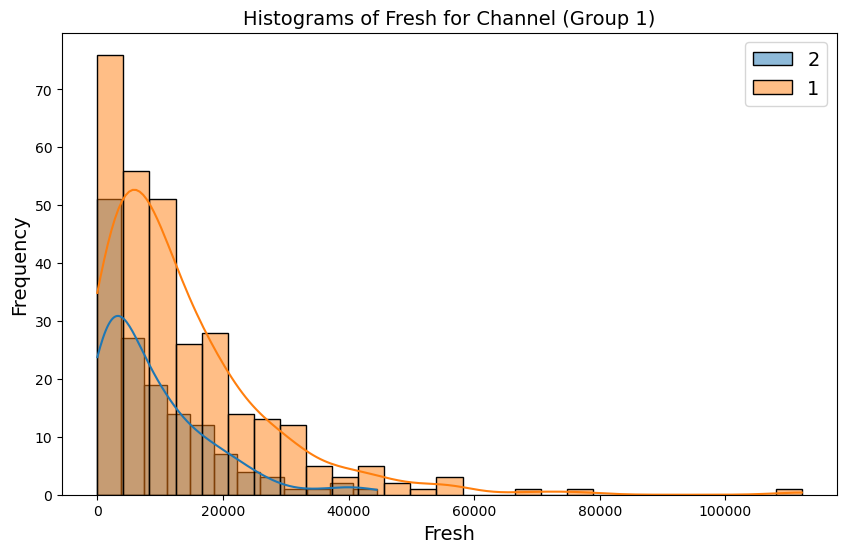

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


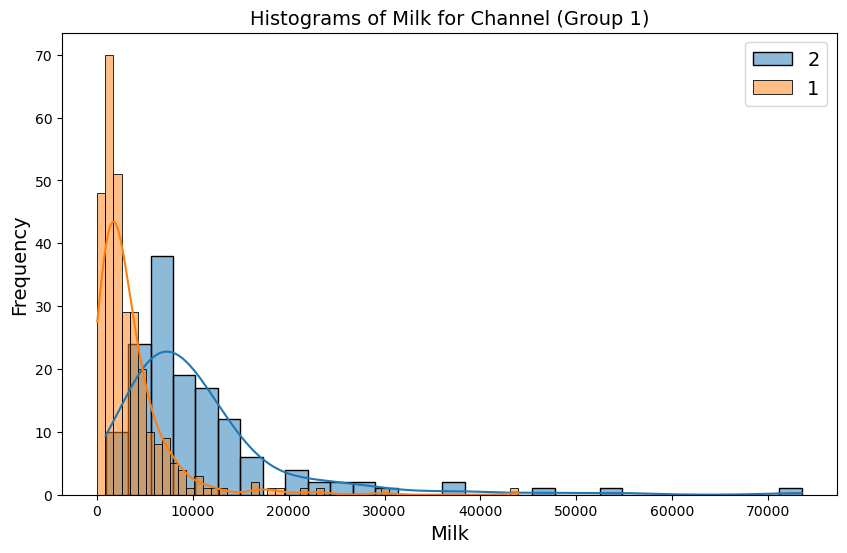

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


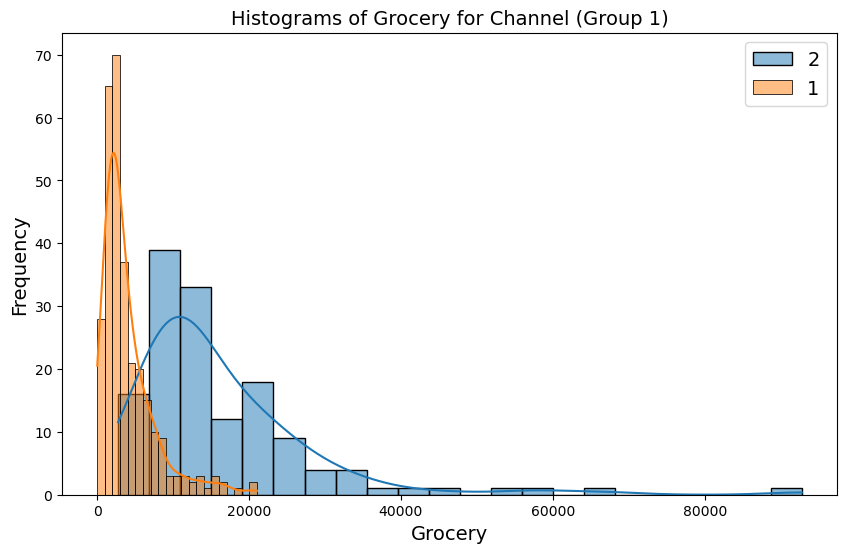

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


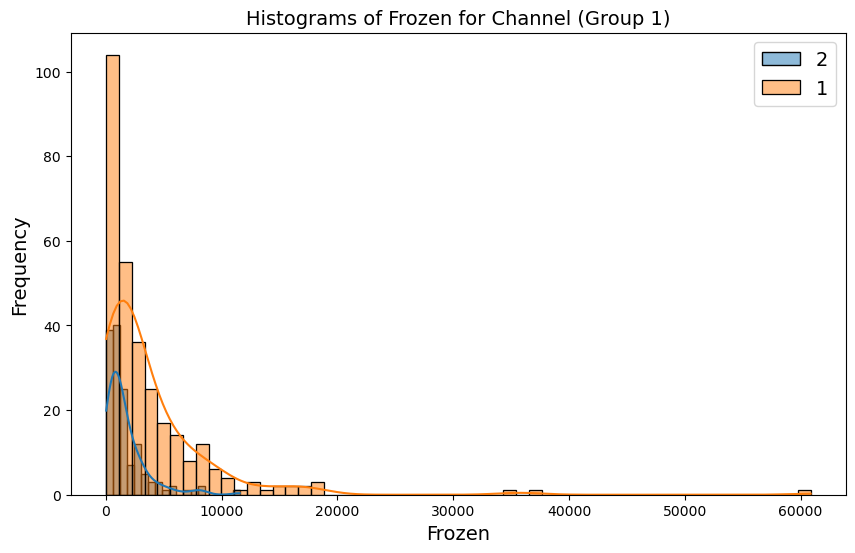

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


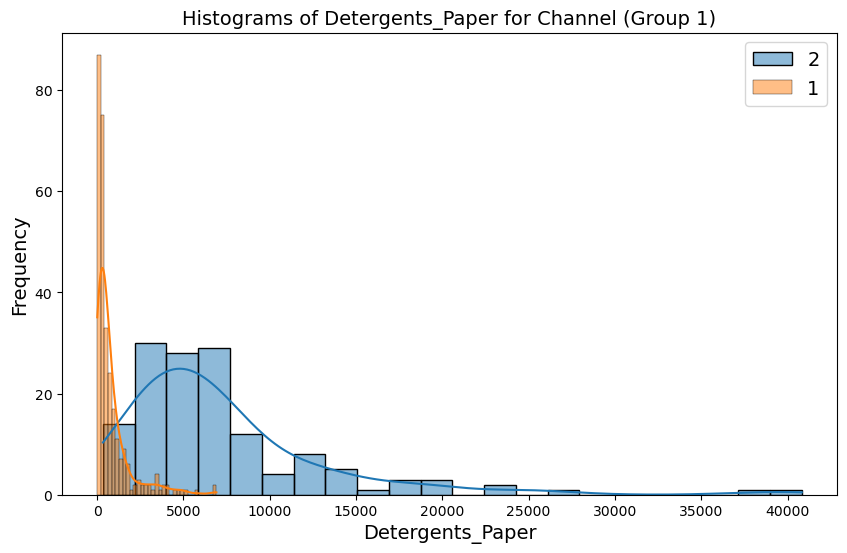

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


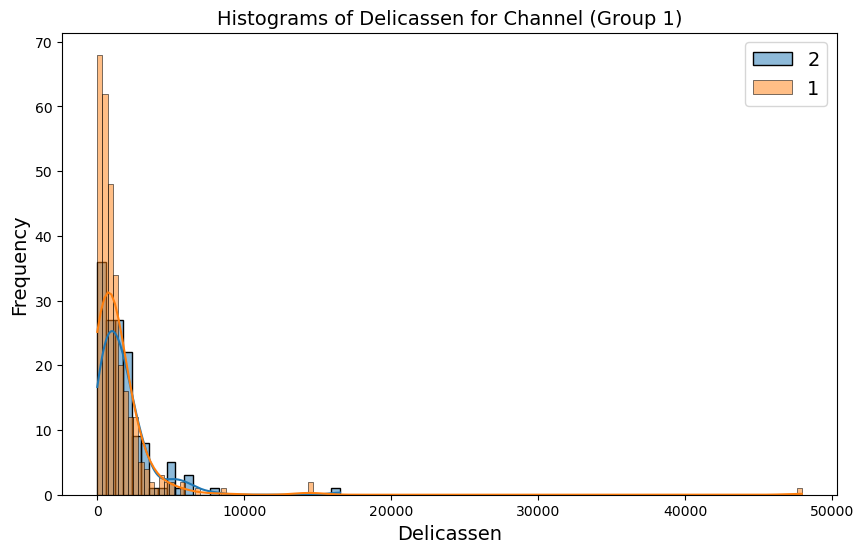

In [21]:
for n in features_num:
    plot_grouped_histograms(df,'Channel', n,20)

### Ejercicio 4

Analicemos los outliers. Obten los outliers a partir de los diagramas de boxplot para todos los datos y luego separados por canal.

### Ejercicio 5

Vamos a intentar detectar posibles agrupaciones en los datos con variables dos a dos. Utiliza un pairplot de sns para mostrar los scatter plots de las variables numéricas dos a dos e intentar visualizar algún clustering e incluso justificar usar kMeans o DBSCAN. En este ejercicio hazlo para todo el dataset.

### Ejercicio 6

Repite el ejercicio 5 pero separando por canal. Emplea el argumento hue del pairplot para no tener que hacer dos pairplots diferentes. 

### Ejercicio 7

Si has logrado hacer los dos ejercicios anteriores (y si no consulta su solución) tendrás una idea un poco más clara de por qué es interesante la clusterización con DBSCAN mejor que con KMeans. Así que vamos a utilizarlo, pero antes escalemos los datos, transformándolos primero (de primeras no vamos a distinguir entre canales, hazlo con todo el dataseet). Es decir aplica la tranformación que creas necesaria en las columnas numéricas que creas conveniente. Hazlo en un dataframe copiado del original para poder interpretar los valores correctamente al final.

### Ejercicio 8

Escala las columnas que creas necesario. Si no lo tienes claro, escala todas.

### Ejercicio 9

En el caso de los modelos no supervisados, una vez hemos tratado las features hay que escoger los hiperparámetros. En el caso de dBSCAN no es el número de clústeres, sino la distancia `eps` que determina el vecindario de un punto y el número de vecinos a partir del cual se decide si una instancia es core o no (`min_samples`). 

Una forma de hacerlo es iterar sobre rangos de estos dos hiperparámetros midiendo el porentaje de "anomalías" que detecta y considerando como punto de parada un valor por debajo del 10%.

NOTA: Usa el doble de cantidad de tus features para el mínimo de elementos y un rango para el epsilon de 0.001 a 3. Para min_samples vamos a usar un valor "estimado" que corresponde a 2 veces el número de features empleadas.

### Ejercicio 10

Entrena un clustering DBSCAN con el valor que hayas encontrado como mejor en el ejercicio anterior (si no has visto claramente un valor, usa eps = 2) y `min_samples` a dos veces el número de features empleadas.

### Ejercicio 11

Agrega las etiquetas generadas con DBSCAN a tu dataframe original e interpreta los resultados (observa el número de etiquetas, recuerda que -1 no es un cluster son anomalías o outliers) luego contesta a: ¿Qué grupos o patrones fué capaz de capturar el DBSCAN? (Haz las tablas de contingencia de las etiquetas con las dos variables categóricas, por separado, por ejemplo y a partir de ahí justifica tu respuesta)